# Contrastive CLIP Reward Estimator

This notebook upgrades the original CLIP‑based reward head by **adding a negative prompt**.  
The reward is the sigmoid‑scaled difference between the cosine similarity of the frame with a **positive** prompt
(*“a red Kong dog toy centered in the frame”*) and a **negative** prompt
(*“an empty kitchen floor with no toy”*).

A centred red Kong should yield rewards ≳ 0.8, while frames with no toy (or off‑centre toy) drop ≲ 0.2.


In [1]:
import os, random, torch, json
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

import config                                   # project‑level config
from importnb import Notebook
with Notebook():
    from jetbot_dataset import JetbotDataset    # same dataset class as before

device = torch.device(config.DEVICE)
print("Using device ➜", device)

# ----------------------------------------------------------------------
# Load CLIP model (ViT‑B/32 for speed; switch to ViT‑L/14 if you have VRAM)
CKPT_PATH = r"C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\clip_kong_finetune\ckpt-final"
clip_model = CLIPModel.from_pretrained(CKPT_PATH, torch_dtype=torch.float16).eval().to(device)
processor   = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")   # or vit-large-patch14
# ----------------------------------------------------------------------
# MODEL_NAME = r"C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\clip_kong_finetune"
# MODEL_NAME = "openai/clip-vit-large-patch14"

#processor = CLIPProcessor.from_pretrained(MODEL_NAME)
#clip_model = CLIPModel.from_pretrained(MODEL_NAME).eval().to(device)

# ----------------------------------------------------------------------
# Encode positive & negative text prompts ONCE
# ----------------------------------------------------------------------
# POS_PROMPT = "a red Kong dog toy in frame"
POS_PROMPT = "a red object on the ground"
NEG_PROMPT = "a kitchen floor with no red object on the ground"

with torch.no_grad():
    pos_emb = clip_model.get_text_features(**processor(text=POS_PROMPT, return_tensors="pt").to(device)).float()
    pos_emb /= pos_emb.norm(p=2, dim=-1, keepdim=True)

    neg_emb = clip_model.get_text_features(**processor(text=NEG_PROMPT, return_tensors="pt").to(device)).float()
    neg_emb /= neg_emb.norm(p=2, dim=-1, keepdim=True)

print("Positive & negative text embeddings ready.")

Using device ➜ cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Positive & negative text embeddings ready.


C:\Projects\pythonenv-deeprl\Lib\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [2]:
def clip_reward(pil_img, tau: float = 50.0):
    """Contrastive CLIP reward ∈[0,1].
    1 ⇒ Kong centred; 0 ⇒ empty floor or off‑centre.

    Args:

        pil_img (PIL.Image): input RGB frame

        tau (float): temperature / scaling of the sigmoid; higher = steeper

    """
    with torch.no_grad():
        inputs  = processor(images=pil_img, return_tensors="pt").to(device)
        img_emb = clip_model.get_image_features(**inputs).float()
        img_emb /= img_emb.norm(p=2, dim=-1, keepdim=True)

        delta = (img_emb @ pos_emb.T) - (img_emb @ neg_emb.T)   # (1,1)
        return torch.sigmoid(tau * delta).item()

In [3]:
# ----------------------------------------------------------------------
# Load your Jetbot dataset exactly as before
# ----------------------------------------------------------------------
IMAGE_SIZE    = config.IMAGE_SIZE
N_PREV_FRAMES = config.NUM_PREV_FRAMES

TRANSFORM = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])

dataset = JetbotDataset(
    csv_path=config.CSV_PATH,
    data_dir=config.DATA_DIR,
    image_size=IMAGE_SIZE,
    num_prev_frames=N_PREV_FRAMES,
    transform=TRANSFORM,
    seed=42,
)
print("Dataset length:", len(dataset))

Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037
Dataset length: 23037


In [4]:
def show_clip_rewards(ds, n=6, title="Contrastive CLIP reward on random samples"):
    idxs = random.sample(range(len(ds)), n)
    plt.figure(figsize=(6, 3*n))
    for i, idx in enumerate(idxs):
        curr_img, _, _ = ds[idx]           # JetbotDataset returns (curr, r, prev)
        pil_img = T.ToPILImage()(curr_img)
        r = clip_reward(pil_img)

        plt.subplot(n, 1, i+1)
        plt.imshow(pil_img)
        plt.axis(False)
        plt.title(f"Reward (centered‑Kong score): {r:.3f}")
    plt.suptitle(title, y=1.02, fontsize=15)
    plt.tight_layout()
    plt.show()



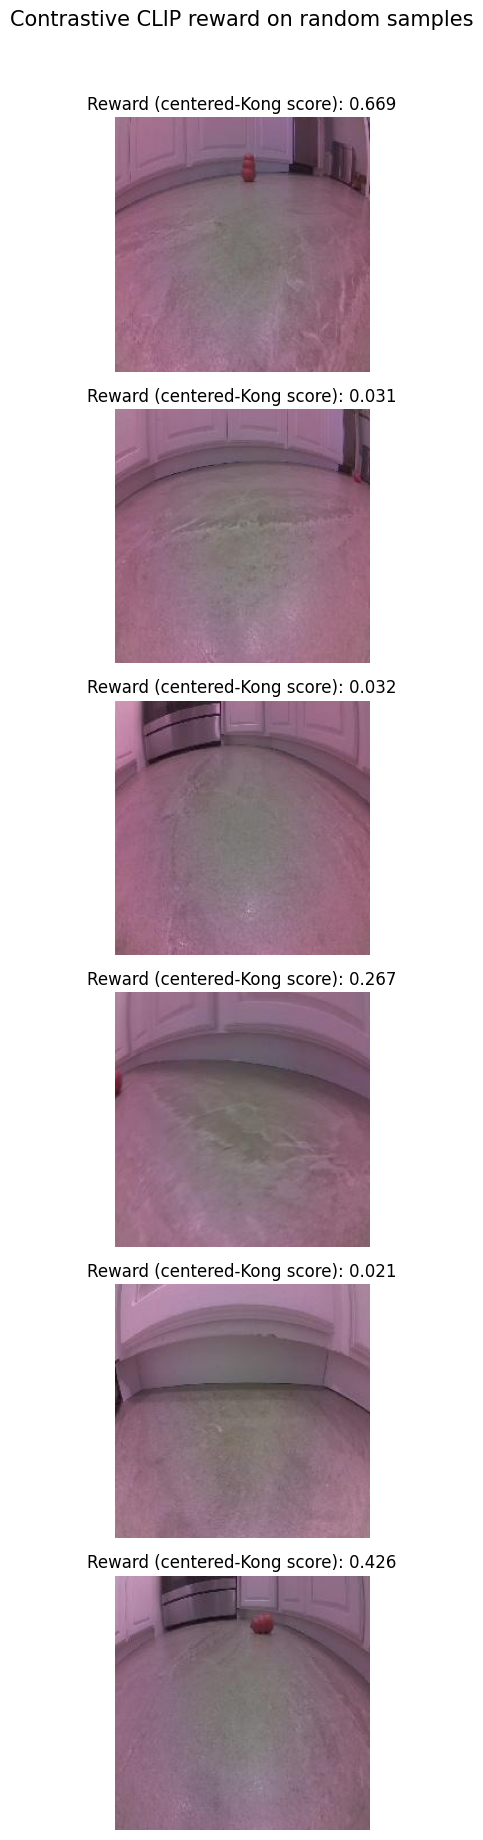

In [8]:
show_clip_rewards(dataset)

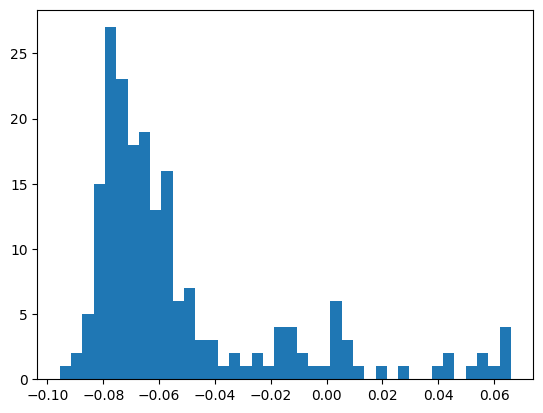

In [10]:
vals = []
for idx in random.sample(range(len(dataset)), 200):
    pil = T.ToPILImage()(dataset[idx][0])
    with torch.no_grad():
        img_emb = clip_model.get_image_features(**processor(images=pil, return_tensors="pt").to(device)).float()
        img_emb /= img_emb.norm(dim=-1, keepdim=True)
        vals.append((img_emb @ pos_emb.T - img_emb @ neg_emb.T).item())
plt.hist(vals, bins=40); plt.show()

In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

image = Image.open("your_image.jpg")
prompts = [
    "a red Kong toy centered",
    "an empty kitchen floor",
    "a person holding a ball",
    "a red dog toy off-center",
]

inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # similarity scores
probs = logits_per_image.softmax(dim=1).detach().numpy()

for p, prob in zip(prompts, probs[0]):
    print(f"{p:<30}: {prob:.4f}")

## (Optional) Live JetBot Reward Stream
Uncomment and adapt the next cell to stream frames from your real JetBot and display the contrastive reward in real time.

In [3]:
from jetbot_remote_client import RemoteJetBot
import ipywidgets as widgets, asyncio, cv2
#
JETBOT_IP  = "192.168.68.65"          # change to your robot's IP
REFRESH_HZ = 15
#
bot = RemoteJetBot(JETBOT_IP)
print("Connected to JetBot at", JETBOT_IP)
#
reward_label = widgets.Label(value="Reward: ---")
display(reward_label)
#
async def live_loop():
    while True:
        bgr = bot.get_frame()
        if bgr is not None:
            rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            pil  = Image.fromarray(rgb)
            r = clip_reward(pil_img=pil)
            reward_label.value = f"Reward: {r:.3f}"
        await asyncio.sleep(1 / REFRESH_HZ)

await live_loop()

INFO:JetBotClient:Connecting to JetBot at 192.168.68.65:18861
INFO:JetBotClient:Connected successfully!


Image(value=b'', format='jpeg', height='300', width='400')

Connected to JetBot at 192.168.68.65


Label(value='Reward: ---')

CancelledError: 